In [1]:
from gerrychain import Graph

In [2]:
# Read Iowa county graph from the json file "IA_county.json"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center

In [3]:
from geopy.distance import geodesic

# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [4]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01

import math
k = 4          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 793605 and U = 801580 and k = 4


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-14


In [6]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [8]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = m.addVars( DG.edges, G.nodes ) 

# add constraints saying that if node i is assigned to node j, 
#   then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can receive flow of type j 
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [9]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29602 rows, 53757 columns and 199290 nonzeros
Model fingerprint: 0x0daec76e
Variable types: 43956 continuous, 9801 integer (9801 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+06, 2e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 209 rows and 450 columns
Presolve time: 0.78s
Presolved: 29393 rows, 53307 columns, 198382 nonzeros
Variable types: 43506 continuous, 9801 integer (9801 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.04s

Solved with dual simple

In [10]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

7094705277.631604
District 0 has population 801314 and contains counties ['Union', 'Story', 'Polk', 'Jasper', 'Monroe', 'Lucas', 'Decatur', 'Clarke', 'Warren', 'Wayne', 'Marion', 'Mahaska', 'Appanoose']

District 1 has population 795575 and contains counties ['Montgomery', 'Sac', 'Audubon', 'Boone', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', "O'Brien", 'Guthrie', 'Sioux', 'Ida', 'Cass', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Madison', 'Palo Alto', 'Ringgold', 'Calhoun', 'Adair', 'Shelby', 'Dickinson', 'Buena Vista', 'Mills', 'Dallas']

District 2 has population 795577 and contains counties ['Keokuk', 'Davis', 'Jones', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Muscatine', 'Washington', 'Cedar', 'Jefferson', 'Clinton', 'Dubuque', 'Jackson', 'Van Buren', 'Johnson']

District 3 has population 797903 and contains coun

In [11]:
# Let's draw it on a map
import geopandas as gpd

In [12]:
# Read Iowa county shapefile from "IA_county.shp"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

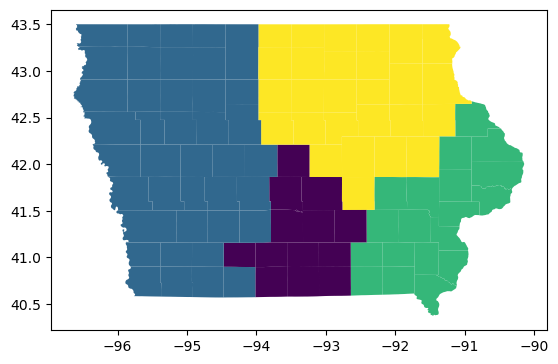

In [13]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()